In [21]:
%reset -f

In [22]:
wavelet = 'SC'

In [23]:
import numpy as np
from matplotlib import pyplot as plt


def get_phi(x, j=None):  # ok
    if wavelet == 'QS':
        # 拟shannon小波
        mm = (3.2**2) * (1**2)
        t = np.pi * x / 1
        ss = np.sin(t) 
        ee = np.exp(-np.square(x) / (2 * mm))
        out = np.divide((ss * ee), t)
        out[np.where(t==0.)] = 1.
        return out
    elif wavelet == 'SC':
        # Shannon Cosine 小波
        zeroidx = np.where(x == 0)
        sc1 = np.zeros_like(x)
        sc1[zeroidx] = 1
        # 其他不为0的地方
        sc1[~(x == 0)] = np.sin(np.pi*x[~(x == 0)]) / (np.pi*x[~(x == 0)])
        Nval = 15.189881678612
        Nval = Nval*(2**j)
        a3 = 0.03125
        a2 = 6 * a3
        a1 = 15 * a3
        a0 = 10 * a3
        xc_tmp = x / Nval
        sc2 = a0 + \
            a1 * np.cos(2*np.pi*xc_tmp) + \
            a2 * np.cos(4*np.pi*xc_tmp) + \
            a3 * np.cos(6*np.pi*xc_tmp)
        
        sc = sc1 * sc2
        
        middle_idx = sc.shape[0] // 2
        idxsc = ((x >= x[middle_idx]-Nval/2) & (x <= x[middle_idx]+Nval/2))
        out = np.zeros_like(sc)
        out[idxsc] = sc[idxsc]  # heaviside函数

    else:
        # FS小波
        out = np.zeros_like(x)
        out[(x >= -1) & (x < 0)] = x[(x >= -1) & (x < 0)] + 1
        out[(x >= 0) & (x <= 1)] = 1 - x[(x >= 0) & (x <= 1)]
        return out

    return out


def get_phi2d(xc, xr, j):  # ok
    return get_phi(xc, j) @ get_phi(xr, j).T


def get_psi2d(j, kc, kr, xc, xr):  # ok
    return get_phi((2 ** (j+1)) * xc - (2*kc+1), j+1) @ get_phi((2 ** (j+1)) * xr - (2*kr+1), j+1).T


def get_idx2d(xc, xr, x_transc, x_transr):  # ok
    diffc = np.abs(xc - x_transc)
    idxc = np.argmin(diffc)
    diffr = np.abs(xr - x_transr)  # 查找插值基对应位置的索引
    idxr = np.argmin(diffr)  # ...
    return [idxc, idxr]


def func(img, xc, xr, x_transc, x_transr):  # ok
    idx = get_idx2d(xc, xr, x_transc, x_transr)
    return img[idx[0], idx[1]], idx


def get_Iwt_l2d(imgl, xc, xr, j):  # ok
    Ijf = 0
    indicies = []
    for kc in range(-2 ** j, 2 ** j + 1, 1):
        for kr in range(-2 ** j, 2 ** j + 1, 1):
            phi_jk = get_phi2d((2 ** j) * xc-kc, (2 ** j) * xr-kr, j)
            x_jkc, x_jkr = kc * (2 ** (-j)), kr * (2 ** (-j))
            f_xjk, idx = func(imgl, xc, xr, x_jkc, x_jkr)
            Ijf += f_xjk * phi_jk
            indicies.append(idx)
    return Ijf, [indicies]


def get_Iwt2d(img, xc, xr, j0, J, e):
    approx, indicies = get_Iwt_l2d(img, xc, xr, j0)  # 逼近结果
    if J <= j0:
        return approx, indicies
    for j in range(j0, J):
        idxs = []
        details = np.zeros_like(approx)
        for kc in np.arange((-2 ** (j+1)-1) / 2, 2 ** (j+1)/2, 0.5):
            for kr in np.arange((-2 ** (j+1)-1) / 2, 2 ** (j+1)/2, 0.5):
                alpha_jk, idx = get_alpha_jk2d(img, xc, xr, j, kc, kr, approx, th=e)
                if (idx[0] + idx[1]) > 0:
                    idxs.append(idx)
                psi_jk = get_psi2d(j, kc, kr, xc, xr)
                details += (alpha_jk * psi_jk)
        approx = approx + details
        indicies.append(idxs)
    return approx, indicies


def get_alpha_jk2d(img, xc, xr, j, kc, kr, u, th):
    x_jkc, x_jkr = (2*kc+1) * (2 ** (-j-1)), (2*kr+1) * (2 ** (-j-1))  # 插值基位置
    f_yjk, idx = func(img, xc, xr, x_jkc, x_jkr)  # 插值基对应待逼近函数点值
    diff = np.abs(f_yjk - u[idx[0], idx[1]])
    if diff > th:
        return f_yjk - u[idx[0], idx[1]], idx
    else:
        return 0, [0, 0]
    

xc = np.arange(-1,1,1/256).reshape((-1,1))
xr = xc.copy()
imgl = np.sin(2*xc).reshape((-1,1)) @ np.cos(5*xr).reshape((1,-1))
xc = np.arange(-1, 1, 2/imgl.shape[0]).reshape((-1,1))
xr = np.arange(-1, 1, 2/imgl.shape[1]).reshape((-1,1))
j0 = 0
J = 7
e = 0.003

In [24]:
def show_approx(imgl, approx, indicies, level_points, s=5, cmap='jet', show_2d_points=True, al=0.5):
    xa = np.arange(approx.shape[0])
    ya = np.arange(approx.shape[1])
    xaa, yaa = np.meshgrid(xa, ya)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xaa, yaa, approx.T, cmap='jet', alpha=al)

    idxnp = []
    if level_points == -1 or level_points >= len(indicies):
        for i in indicies:
            idxnp = idxnp + i
    else:
        idxnp = indicies[level_points]
    idxs = np.array(idxnp)
    idxsu = np.unique(idxs, axis=0).T
    idxsut = (idxsu[1,:], idxsu[0,:])
    ax.scatter(xaa[idxsut], yaa[idxsut], approx.T[idxsut], color='black', marker='o', s=2*s)

    ax.set_title('points_num: {}'.format(len(idxnp)))

    plt.figure()
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(approx, cmap=cmap)
    axs[0].set_title('approx_img')
    axs[1].imshow(imgl, cmap=cmap)
    axs[1].set_title('raw_img')
    if show_2d_points:
        if cmap == 'gray':
            color = 'red'
        else:
            color = 'black'
        points = list(zip(idxsut[0], idxsut[1]))
        x1, y1 = zip(*points)
        axs[1].scatter(x1, y1, color=color, s=s)

    plt.show()


def show_3d_points(approx, indicies, level_points=2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    indicieslevel = len(indicies)
    if level_points == -1 or level_points >= len(indicies):
        pass
    else:
        indicies = [indicies[level_points]]
    for idx, i in enumerate(indicies):
        i = np.array(i)
        idxsu = np.unique(i, axis=0).T
        if len(idxsu) == 0:
            continue
        idxsut = (idxsu[1,:], idxsu[0,:])
        xa = np.arange(approx.shape[0])
        ya = np.arange(approx.shape[1])
        xaa, yaa = np.meshgrid(xa, ya)
        amm = np.zeros_like(approx)
        if level_points == -1 or level_points >= indicieslevel:
            d = idx
        else:
            d = level_points
        amm[i[:,0], i[:,1]] = d
        ax.set_xlim([0, approx.shape[0]])
        ax.set_ylim([0, approx.shape[1]])
        ax.set_zlim([0, indicieslevel])
        ax.scatter(xaa[idxsut], yaa[idxsut], amm.T[idxsut], marker='o', s=(indicieslevel-idx+1)*5)
    plt.show()

In [25]:
# approx, indicies = get_Iwt2d(imgl, xc, xr, j0, J, e)
import time
times = []
l2errs = []
for i in range(10):
    start = time.time()
    approx, indicies = get_Iwt2d(imgl, xc, xr, j0, J, e)
    end = time.time()
    times.append(end - start)
    l2err = np.linalg.norm(imgl - approx, 2) / np.linalg.norm(imgl, 2)
    l2errs.append(l2err)

In [26]:
print('time: ', np.mean(times), 's', np.std(times))
print('l2err: {:e}'.format(np.mean(l2errs)))

time:  183.96192762851715 s 3.2329662843523486
l2err: 1.450389e-03


In [27]:
# print(len(indicies))

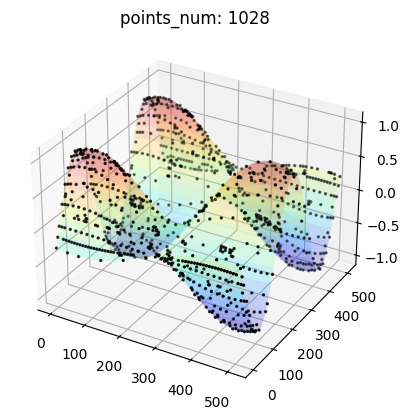

<Figure size 640x480 with 0 Axes>

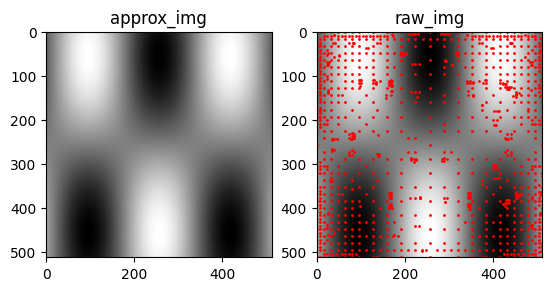

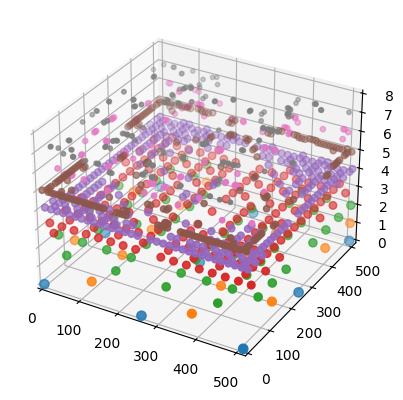

In [28]:
l=-1
show_approx(imgl, approx, indicies, level_points=-1, s=1, cmap='gray', show_2d_points=True, al=0.2)
show_3d_points(approx, indicies, level_points=l)

In [29]:
# plt.plot(approx[24,:])
# plt.plot(imgl[24,:])